In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from os import listdir
from keras.preprocessing import image
from keras.utils import np_utils
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201
from sklearn.metrics import accuracy_score

In [2]:
path = "../../Dataset/"
files = listdir("../../Dataset/")
print(files)

['EA', 'EH', 'EP', 'NE']


In [3]:
data = pd.DataFrame(index=np.arange(0, 3302), columns=["class_id", "subtype", "path"])

k = 0
total_images = 0
for n in range(len(files)):
    class_id = files[n]
    class_path = path + class_id + '/'

    if class_id == 'EA':
        images = listdir(class_path)
        total_images += len(images)
        
        for m in range(len(images)):
            if images[m] == 'Thumbs.db':
                continue
            image_path = class_path + images[m]
            data.iloc[k]["class_id"] = "Malignant"
            data.iloc[k]["subtype"] = "None"
            data.iloc[k]["path"] = image_path
            k += 1

        if 'Thumbs.db' in images: 
            total_images -= 1


    if class_id == 'EP':
        images = listdir(class_path)
        total_images += len(images)
        
        for m in range(len(images)):
            if images[m] == 'Thumbs.db':
                continue
            image_path = class_path + images[m]
            data.iloc[k]["class_id"] = "Benign"
            data.iloc[k]["subtype"] = "None"
            data.iloc[k]["path"] = image_path
            k += 1

        if 'Thumbs.db' in images: 
            total_images -= 1


    elif class_id == 'EH' or class_id == 'NE':
        subtypes = listdir(class_path)
        for c in range(len(subtypes)):
            subtype = subtypes[c]
            subtype_path = class_path + subtype + '/'
            images = listdir(subtype_path)
            total_images += len(images)
        
            for m in range(len(images)):
                if images[m] == 'Thumbs.db':
                    continue
                image_path = subtype_path + images[m]
                data.iloc[k]["class_id"] = "Benign"
                data.iloc[k]["subtype"] = subtype
                data.iloc[k]["path"] = image_path
                k += 1

            if 'Thumbs.db' in images: 
                total_images -= 1

print(total_images)
print(data.shape)
data.head()

3302
(3302, 3)


,class_id,subtype,path
0,Malignant,None,../../Dataset/EA/1509779.JPG
1,Malignant,None,../../Dataset/EA/1509806.JPG
2,Malignant,None,../../Dataset/EA/1510326.JPG
3,Malignant,None,../../Dataset/EA/1510326ú¿2ú⌐.JPG
4,Malignant,None,../../Dataset/EA/1510326ú¿3ú⌐.JPG


In [4]:
data['class_id'].value_counts()

Benign       2767
Malignant     535
Name: class_id, dtype: int64

In [5]:
train_image = []
y = []

for i in tqdm(range(data.shape[0])):
    img = image.load_img(data['path'].iloc[i], target_size=(299,299,1), grayscale=False)
    img = image.img_to_array(img)
    img = img/255

    train_image.append(img)

    if data.iloc[i]['class_id'] == "Benign":
        y.append(0)
    elif data.iloc[i]['class_id'] == "Malignant":
        y.append(1)

X = np.array(train_image)
Y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size=0.1 , shuffle=True)

Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)
Y_val = np_utils.to_categorical(y_val, 2)

100%|██████████| 3302/3302 [00:35<00:00, 93.97it/s] 


In [6]:
import pandas as pd
from random import shuffle
import numpy as np
import cv2
import glob
import gc
import os
import tensorflow as tf
import tensorflow.keras.backend as K

from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, merge
from keras.layers import SeparableConv2D,ReLU, Dense, Dropout, Flatten, GlobalAvgPool2D, MaxPool2D, Activation, Input, BatchNormalization, multiply, Add, GlobalAveragePooling2D,AveragePooling2D,GlobalMaxPooling2D,concatenate
from keras.layers import dot, Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D, MaxPool1D, Activation, Flatten, Conv2D, Conv1D, Conv3D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, Callback, TensorBoard,CSVLogger
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras.models import Model,load_model
from tensorflow.keras import Input
from tensorflow.keras.applications import NASNetMobile,MobileNetV2,densenet,resnet50,xception,InceptionV3, VGG16

from albumentations import Resize,Compose, RandomRotate90, Transpose, Flip, OneOf, CLAHE, IAASharpen, IAAEmboss, RandomBrightnessContrast, JpegCompression, Blur, GaussNoise, HueSaturationValue, ShiftScaleRotate, Normalize

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from skimage import data, exposure
import itertools
import shutil
import matplotlib.pyplot as plt
import gc

In [56]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [57]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [77]:
# creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# entry flow

def entry_flow(x):
    x = conv_bn(x, filters =1024, kernel_size =3, strides=1)
    x = ReLU()(x)
    x = conv_bn(x, filters =2048, kernel_size =3, strides=1)
    tensor = ReLU()(x)

    """
    x = sep_bn(tensor, filters = 2048, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=1, padding = 'same')(x)
    """

    tensor = Conv2D(filters=2048, kernel_size = 1, strides=1, padding = 'same', use_bias = False)(x)
    tensor = BatchNormalization()(tensor)
    x = Add()([tensor,x])

    conv_name_base = 'res' + str(2) + 'a' + '_branch'
    bn_name_base = 'bn' + str(2) + 'a' + '_branch'

    F1, F2, F3 = [512, 512, 1024]

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    



    conv_name_base = 'res' + str(2) + 'b' + '_branch'
    bn_name_base = 'bn' + str(2) + 'b' + '_branch'
    F1, F2, F3 = [512, 512, 1024]

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)
    

    
    #X = identity_block(X, 3, [512, 512, 1024], stage=2, block='b')
    
    return x
# middle flow
"""
def middle_flow(tensor):

    X = convolutional_block(tensor, f=3, filters=[128, 128, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [128, 128, 256], stage=2, block='b')
    X = identity_block(X, 3, [128, 128, 256], stage=2, block='c')

    X = convolutional_block(tensor, f=3, filters=[256, 256, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 512], stage=3, block='b')
    X = identity_block(X, 3, [256, 256, 512], stage=3, block='c')
    X = identity_block(X, 3, [256, 256, 512], stage=3, block='d')
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
    
    return X"""
# exit flow

def exit_flow(tensor):
    """
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 512,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =512, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    """
    x = GlobalAvgPool2D()(tensor)
    
    x = Dense (units = 1024, activation = 'relu')(x)
    x = Dense (units = 512, activation = 'relu')(x)
    x = Dense (units = 2, activation = 'relu')(x)
    
    return x

In [7]:
adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)
K.set_learning_phase(1)
base_model = InceptionV3(input_tensor=Input(shape=(299, 299, 3)), weights='imagenet', include_top=False)

x = base_model.output

x = Conv2D(filters=1024, kernel_size = 3, strides=1, padding = 'same', use_bias = False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(filters=2048, kernel_size = 3, strides=1, padding = 'same', use_bias = False)(x)
x = BatchNormalization()(x)
tensor = ReLU()(x)

tensor = Conv2D(filters=2048, kernel_size = 1, strides=1, padding = 'same', use_bias = False)(x)
tensor = BatchNormalization()(tensor)
x = Add()([tensor,x])



conv_name_base = 'res' + str(2) + 'a' + '_branch'
bn_name_base = 'bn' + str(2) + 'a' + '_branch'

F1, F2, F3 = [512, 512, 1024]

X = x
X_shortcut = X

X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a')(X)
X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
X = Activation('relu')(X)

X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
X = Activation('relu')(X)

X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '1')(X_shortcut)
X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

X = Add()([X, X_shortcut])
X = Activation('relu')(X)

    



conv_name_base = 'res' + str(2) + 'b' + '_branch'
bn_name_base = 'bn' + str(2) + 'b' + '_branch'
F1, F2, F3 = [512, 512, 1024]

X_shortcut = X
   
X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a')(X)
X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
X = Activation('relu')(X)

X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
X = Activation('relu')(X)

X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

X = Add()([X, X_shortcut])# SKIP Connection
X = Activation('relu')(X)



x = GlobalAvgPool2D()(X)
    
x = Dense (units = 1024, activation = 'relu')(x)
x = Dense (units = 512, activation = 'relu')(x)
x = Dense (units = 2, activation = 'softmax')(x)


print(x.shape)


# model code
"""
input = Input(shape = x.shape)
x = entry_flow(input)
#x = middle_flow(x)
output = exit_flow(x)
"""

"""
# K.set_learning_phase(1)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
for layer in (base_model.layers):
    layer.trainable = False
    if layer.name.startswith('bn') or 'bn' in layer.name:
        layer.call(layer.input, training=False)
"""
model = Model(inputs=base_model.input, outputs=x)
adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[keras.metrics.categorical_accuracy])
model.summary()

c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


(None, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                   

In [9]:
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        zca_whitening=False,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

learn_control = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.5, cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(monitor='val_categorical_accuracy', min_delta=1e-4, patience=50)


filepath = "weights.best.hdf5"
#'./tmpinception/' + '-weights.{epoch:02d}-{categorical_accuracy:.4f}-{val_loss:.4f}-{val_categorical_accuracy:.4f}.h5'
#csv_file = './tmpinception/record.csv'
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=2, save_weights_only=True, mode='max')

tensorboard = TensorBoard(log_dir='./logs/', histogram_freq=0, batch_size=8, write_graph=True,
                              write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None,
                              embeddings_metadata=None)
#CSV_record = CSVLogger(csv_file, separator=',', append=True)

history = model.fit_generator(
        train_generator.flow(X_train, Y_train, batch_size=32),
        steps_per_epoch=X_train.shape[0]/32,
        initial_epoch=0,
        epochs=20,
        verbose=1,
        validation_data=(X_val, Y_val),
        callbacks=[learn_control, early_stopper, checkpoint, tensorboard])

C:\Users\Dell\AppData\Local\Temp/ipykernel_20280/2739579.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
83/82 [==============================] - ETA: -12s - loss: 0.6896 - categorical_accuracy: 0.8148
Epoch 00001: saving model to weights.best.hdf5
82/82 [==============================] - 2252s 27s/step - loss: 0.6896 - categorical_accuracy: 0.8148 - val_loss: 122280336.0000 - val_categorical_accuracy: 0.8060 - lr: 0.0050
Epoch 2/50
83/82 [==============================] - ETA: -13s - loss: 0.4415 - categorical_accuracy: 0.8463
Epoch 00002: saving model to weights.best.hdf5
82/82 [==============================] - 2328s 28s/step - loss: 0.4415 - categorical_accuracy: 0.8463 - val_loss: 0.4983 - val_categorical_accuracy: 0.8060 - lr: 0.0050
Epoch 3/50
83/82 [==============================] - ETA: -13s - loss: 0.4412 - categorical_accuracy: 0.8463
Epoch 00003: saving model to weights.best.hdf5
82/82 [==============================] - 2345s 28s/step - loss: 0.4412 - categorical_accuracy: 0.8463 - val_loss: 0.6618 - val_categorical_accuracy: 0.8060 - lr: 0.0050
Epoch 4/50
83/82 [==

In [4]:
history_df = pd.DataFrame(history.history)
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

NameError: name 'history' is not defined

<AxesSubplot:>

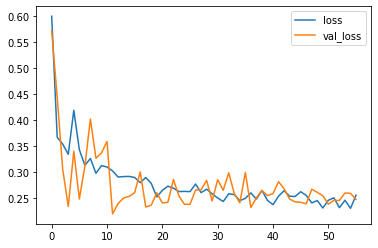

In [10]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [11]:
Y_val_pred = model.predict(X_val)

In [12]:
accuracy_score(np.argmax(Y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.8656716417910447

In [13]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

categorical_accuracy: 92.76%


In [17]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=32, shuffle=False),
                                    steps = len(X_test)/32)
    
    predictions.append(preds)
    gc.collect()
Y_pred_tta = np.mean(predictions, axis=0)
    

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Dell\AppData\Local\Temp/ipykernel_904/1110878815.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=32, shuffle=False),
100%|██████████| 10/10 [14:36<00:00, 87.68s/it]


Confusion matrix, without normalization
[[473   5]
 [ 59  57]]


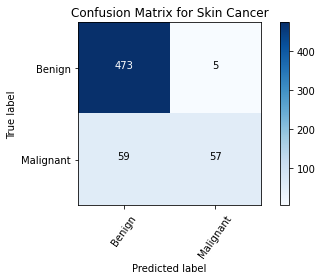

In [20]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['Benign', 'Malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Skin Cancer')

In [21]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.89      0.99      0.94       478\n           1       0.92      0.49      0.64       116\n\n    accuracy                           0.89       594\n   macro avg       0.90      0.74      0.79       594\nweighted avg       0.90      0.89      0.88       594\n'

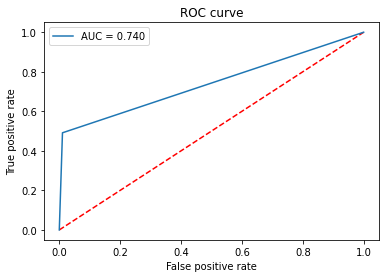

In [22]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()